## Energy proxy traits example

Here we present a simple example for computing energy proxy traits (EPTs) from bio-imaging footage of *Radix Balthica* embryos. Note that this example demonstrates the computation and visualisation of EPTs for a single timepoint in an embryos development, and thus does not include methods for the integration of responses from multiple individuals and/or treatment groups. There is also no pre-processing step involving the segmentation of the embryo from the image. For these methods, please see the following repository: https://github.com/otills/embryocv.




**Libraries and parameters**

For this example we will require the following libraries:

In [ ]:
!pip install scikit-image
!pip install numpy
!pip install vuba
!pip install wget
!pip install matplotlib
!pip install opencv-python
!pip install scipy


In [3]:
# Retrieval of source data
import wget

# Image handling
from skimage.util import view_as_blocks
import numpy as np 
import vuba
import cv2
import math

# Power spectral analysis
from scipy import signal

# Plotting 
import matplotlib.pyplot as plt

For the analysis below, we will also require the following parameters:

In [4]:
# Grid size for EPT calculation 
blocksize = 8

# Path to footage to analyse
path = 'https://zenodo.org/record/4645805/files/20C_A1_10d.avi?download=1'

**Computation of EPTs**

Now that we have defined our required parameters and imported the necessary libraries, we can retrieve our sample video:



In [5]:
path = wget.download(path)
video = vuba.Video(f'./{path}')
frames = video.read(0, len(video), grayscale=True)

In the above code, we have retrieved our sample video and created a [`Video`](https://vuba.readthedocs.io/en/latest/generated/vuba.Video.html#vuba.Video) handler for reading in frames using [`vuba`](https://vuba.readthedocs.io/en/latest/). Since the steps below require grayscale images, we have also specified that all frames should be grayscaled once imported. To have a look at a single frame from this video, we can simply do the following:

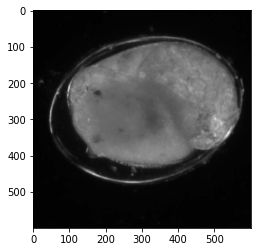

In [21]:
first_frame = video.read(index=0, grayscale=True)
plt.imshow(first_frame, cmap='gray')

We will be computing EPTs at an 8 x 8 resolution, and so we must ensure that the image arrays for each frame are divisible by 8 so that they can be split up into an 8 x 8 blockwise grid. A simple way to achieve this is to crop individual frames to a suitable resolution:

In [7]:
def crop(frame):
    '''Crop an image according to the blocksize required for EPT calculation.'''
    # Floor used so new image size is always below the original resolution
    new_x, new_y = map(lambda v: math.floor(v/blocksize)*blocksize, frame.shape) 
    return frame[:new_x, :new_y]

Prior to signal decomposition, we will need to compute mean pixel values for our 8 x 8 blockwise resolution. To do this we can leverage [`view_as_blocks`](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.view_as_blocks) from the popular python image processing package [scikit-image](https://scikit-image.org/). This function enables us to split our individual frames into a blockwise grid of smaller, equal sized images that we can compute the mean pixel values for as follows: 

In [23]:
x,y = video.resolution
block_shape = tuple(map(int, (x/blocksize, y/blocksize))) # size of each image block
blocks = view_as_blocks(crop(first_frame), block_shape)

We can also visualise the output of this function like so:

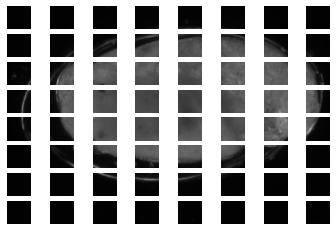

In [26]:
fig, axs = plt.subplots(blocksize, blocksize, sharex=True)

for i in range(blocksize):
    for j in range(blocksize):
        ax = axs[i,j]
        ax.imshow(blocks[i,j], cmap='gray', vmin=0, vmax=255)
        ax.set_axis_off()

plt.show()

Because [`view_as_blocks`](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.view_as_blocks) returns a numpy array, we can simply compute the mean pixel values for our sample video using the following:

In [27]:
mpx = np.asarray([view_as_blocks(frame, block_shape).mean(axis=(2,3)) for frame in map(crop, frames)])

Now that we've computed mean pixel values for our sample video, we can perform signal decomposition on these data to retrieve the power spectra that make up energy proxy traits. To do this we will be using [welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) to convert our mean pixel value signals to the frequency domain:

In [33]:
epts = np.empty((blocksize, blocksize, 2, int(len(video)/2)+1))
for i in range(blocksize):
    for j in range(blocksize):
        epts[i,j,0,:], epts[i,j,1,:] = signal.welch(mpx[:,i,j], fs=video.fps, scaling='spectrum', nfft=len(mpx))

**Visualisation of EPTs**

Lastly, we can readily visualise the mean pixel values and EPTs we computed above using [matplotlib](https://matplotlib.org/3.1.0/index.html) [subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) like so:

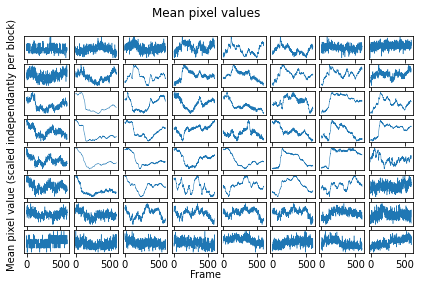

In [30]:
fig, axs = plt.subplots(blocksize, blocksize, sharex=True)
fig.subplots_adjust(left=0.08, right=0.98, wspace=0.1)

for i in range(blocksize):
    for j in range(blocksize):
        ax = axs[i,j]
        ax.set_autoscale_on(True)
        ax.get_yaxis().set_visible(False)
        ax.plot(mpx[:,i,j], linewidth=0.5)

fig.suptitle('Mean pixel values')
fig.text(0.5, 0.04, 'Frame', ha='center')
fig.text(0.04, 0.5, 'Mean pixel value (scaled independantly per block)', va='center', rotation='vertical')
plt.show()

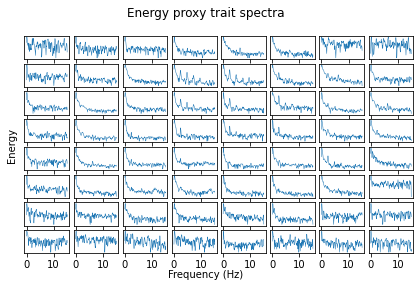

In [34]:
fig, axs = plt.subplots(blocksize, blocksize, sharex=True)
fig.subplots_adjust(left=0.08, right=0.98, wspace=0.1)

for i in range(blocksize):
    for j in range(blocksize):
        ax = axs[i,j]
        ax.set_autoscale_on(True)
        ax.get_yaxis().set_visible(False)
        ax.plot(epts[i,j,0,:], np.log(epts[i,j,1,:]), linewidth=0.5)

fig.suptitle('Energy proxy trait spectra')
fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center')
fig.text(0.04, 0.5, 'Energy', va='center', rotation='vertical')
plt.show()